## Loading the corrupted dataset

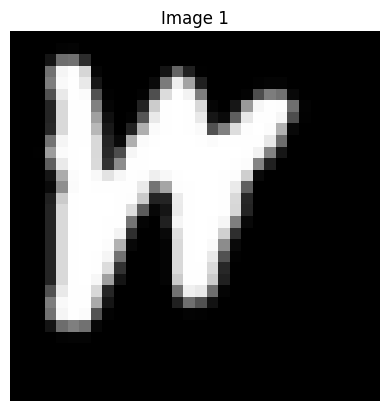

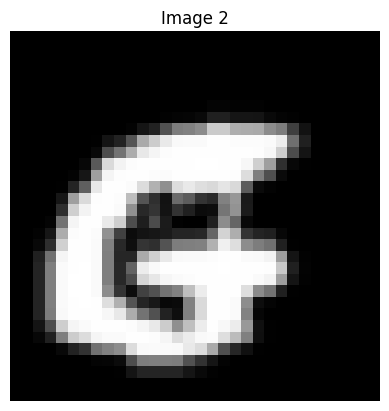

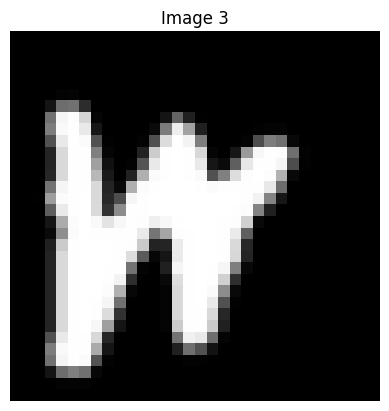

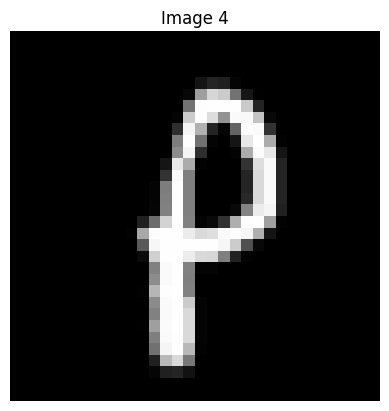

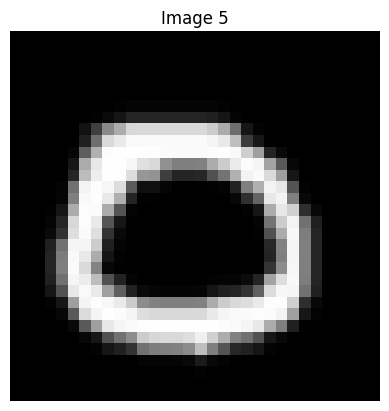

In [19]:
import numpy as np
import zipfile
import matplotlib.pyplot as plt


# Open and extract images from the .zip file
def load_images_from_zip(zip_filename):
    """
    Load a numpy array from a .zip archive containing a .npz file.

    Args:
        zip_filename (str): The name of the .zip file to read.

    Returns:
        numpy.ndarray: The loaded array.
    """
    with zipfile.ZipFile(zip_filename, "r") as zipf:
        npz_filename = zipf.namelist()[0]  # Get the name of the .npz file
        zipf.extract(npz_filename)  # Extract the .npz file
    data = np.load(npz_filename)["all_imagesfinal"]  # Load the array
    return data


# Example usage
loaded_images = load_images_from_zip("corrupted_emnist.zip")

# Show the first 5 images
for i in range(5):
    plt.imshow(loaded_images[i], cmap="gray")
    plt.title(f"Image {i+1}")
    plt.axis("off")
    plt.show()

In [20]:
len(loaded_images)

131057

In [21]:
loaded_images.shape

(131057, 32, 32)

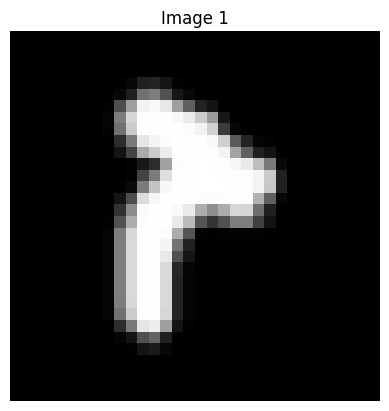

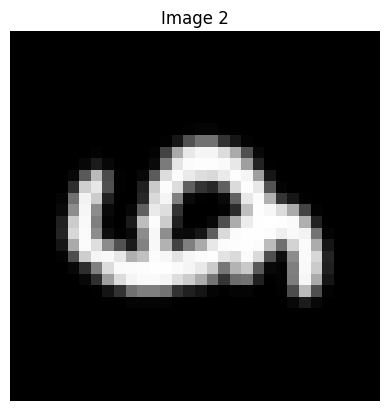

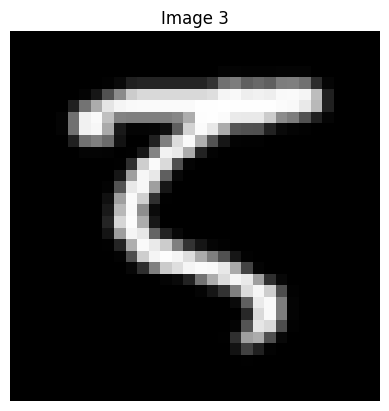

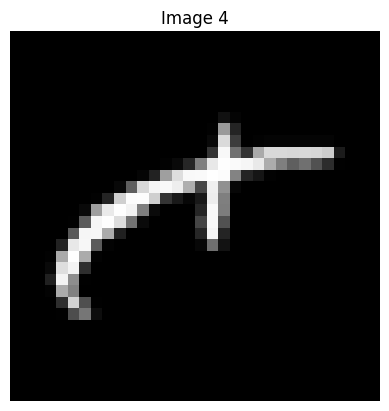

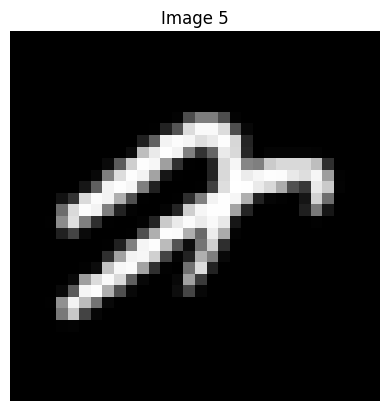

In [22]:
# Generated code

import gzip


# Function to extract images from the IDX3 file
def extract_images(file_path):
    with gzip.open(file_path, "rb") as f:
        # Skip the header (16 bytes)
        f.read(16)
        # Read the image data
        buffer = f.read()
        # Reshape into 28x28 arrays (native EMNIST format)
        data = np.frombuffer(buffer, dtype=np.uint8).reshape(-1, 28, 28)
    return data


# Path to the correct image file
file_path = "emnist-balanced-train-images-idx3-ubyte.gz"

# Extract EMNIST images
original_emnist_images = extract_images(file_path)


# Resize to 32x32 (Padding)
def resize_to_32x32(images):
    return np.pad(images, ((0, 0), (2, 2), (2, 2)), mode="constant")


# Pad EMNIST images to match 32x32
emnist_images_resized = resize_to_32x32(original_emnist_images)

# Show the first 5 padded images
for i in range(5):
    plt.imshow(emnist_images_resized[i], cmap="gray")
    plt.title(f"Image {i+1}")
    plt.axis("off")
    plt.show()


In [23]:
emnist_images_resized.shape

(112800, 32, 32)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using {device}")

Using cuda


In [34]:
# Normalize & Convert to tensors
emnist_images_resized = emnist_images_resized / 255.0
emnist_images_tensor = torch.tensor(emnist_images_resized, dtype=torch.float32)
emnist_images_tensor = emnist_images_tensor.unsqueeze(1)


# Create a DataLoader
batch_size = 128
dataset = TensorDataset(emnist_images_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [35]:
# # Adapted Convolutional Autoencoder from the la on AE_NoisyAE
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                64, 32, kernel_size=3, stride=2, output_padding=1, padding=1
            ),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(
                32, 16, kernel_size=3, stride=2, output_padding=1, padding=1
            ),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(
                16, 1, kernel_size=3, stride=2, output_padding=1, padding=1
            ),  # 16x16 -> 32x32
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [36]:
# Initialize and train the model
model = ConvAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()


# Training loop
def train_model(model, loss_fn, train_loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for (data,) in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")


In [37]:
train_model(model, loss_fn, train_loader, optimizer, epochs=3)

Epoch 1, Loss: 0.007205426949866542
Epoch 2, Loss: 3.7058712854963637e-06
Epoch 3, Loss: 3.898357586132448e-06


In [38]:
corrupted_images = loaded_images / 255.0
corrupted_images_tensor = torch.tensor(corrupted_images, dtype=torch.float32)
corrupted_images_tensor = corrupted_images_tensor.unsqueeze(1)

In [39]:
# Evaluate reconstruction error on corrupted data
model.eval()
with torch.no_grad():
    corrupted_data = corrupted_images_tensor.to(
        device
    )  # Ensure this tensor is prepared
    reconstructed = model(corrupted_data)
    reconstruction_errors = torch.mean(
        (reconstructed - corrupted_data) ** 2, dim=(1, 2, 3)
    )
    print(f"Mean Reconstruction Error: {reconstruction_errors.mean().item()}")


Mean Reconstruction Error: 0.10852106660604477


In [41]:
# Evaluate reconstruction errors
def detect_anomalies(model, corrupted_data, threshold_factor=3):
    model.eval()
    with torch.no_grad():
        corrupted_data = corrupted_data.to(device)
        reconstructed = model(corrupted_data)
        # Calculate reconstruction errors
        errors = torch.mean((reconstructed - corrupted_data) ** 2, dim=(1, 2, 3))
        errors = errors.cpu().numpy()
        # Set anomaly threshold
        threshold = errors.mean() + threshold_factor * errors.std()
        anomalies = errors > threshold
        return anomalies, errors, threshold


# Detect anomalies in the corrupted dataset
anomalies, errors, threshold = detect_anomalies(model, corrupted_images_tensor)
print(f"Detected {anomalies.sum()} anomalies out of {len(errors)} images.")


Detected 547 anomalies out of 131057 images.


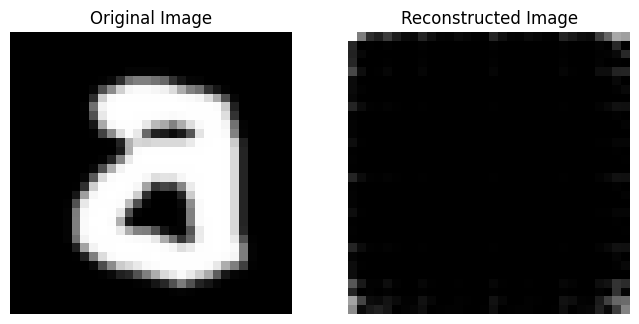

Reconstruction Error: 0.2572137713432312
----


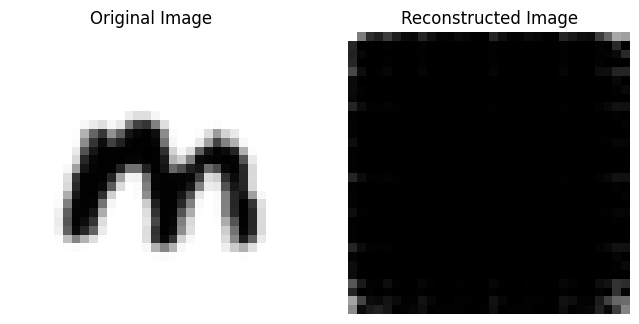

Reconstruction Error: 0.8153097629547119
----


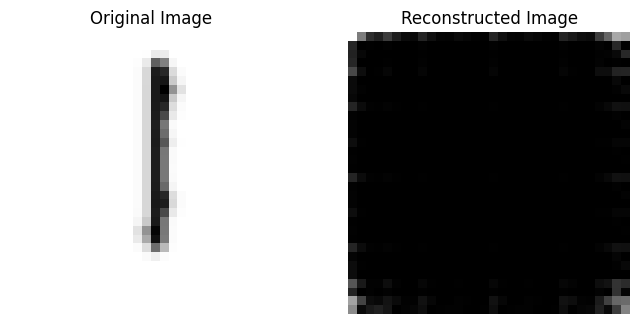

Reconstruction Error: 0.9479905366897583
----


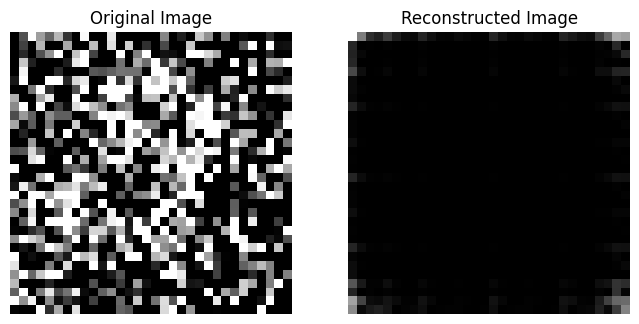

Reconstruction Error: 0.2888171076774597
----


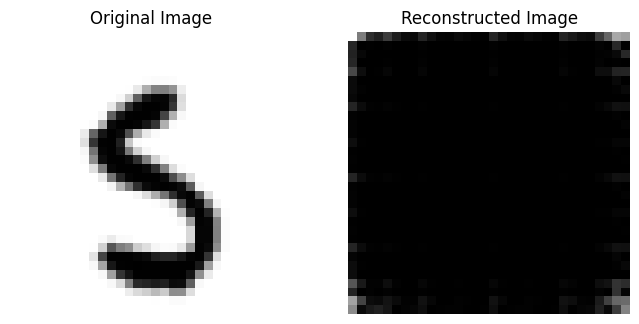

Reconstruction Error: 0.8480374217033386
----


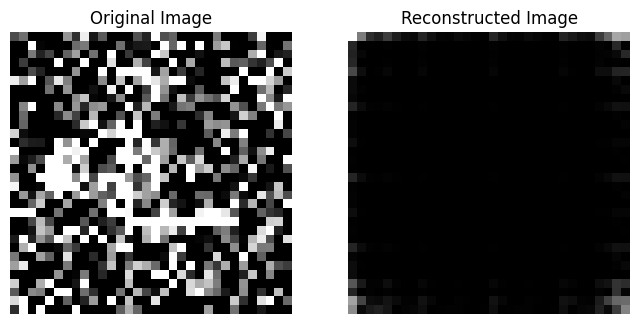

Reconstruction Error: 0.2581411898136139
----


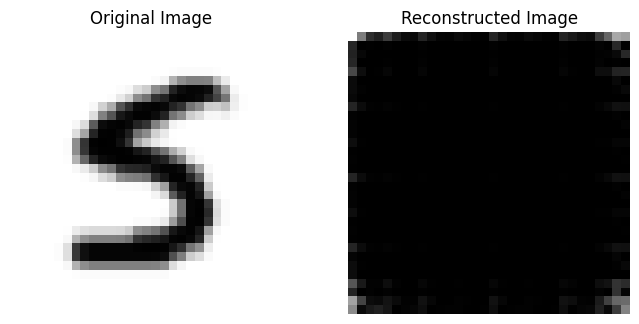

Reconstruction Error: 0.805730938911438
----


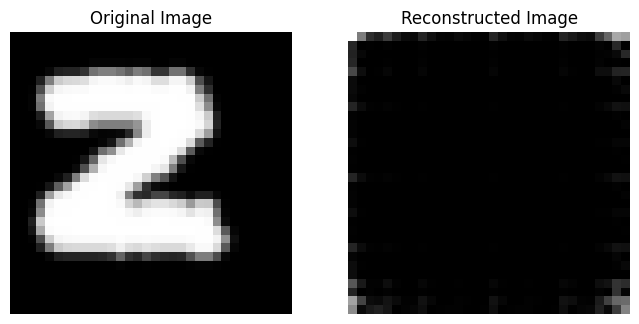

Reconstruction Error: 0.26403623819351196
----


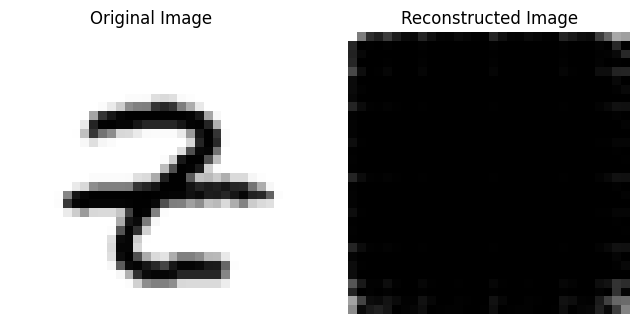

Reconstruction Error: 0.8217010498046875
----


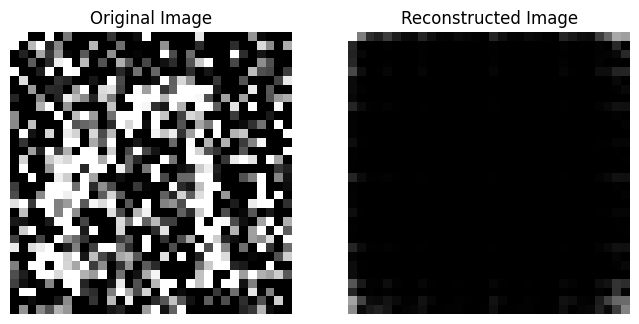

Reconstruction Error: 0.28646111488342285
----


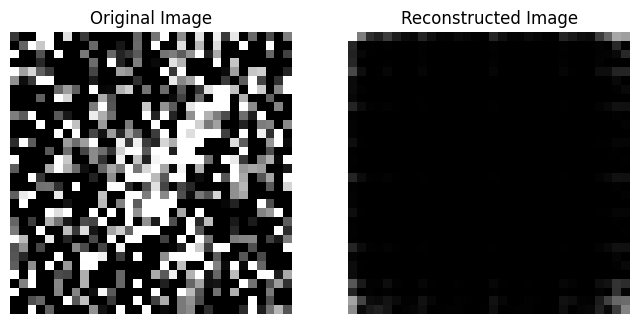

Reconstruction Error: 0.2573784589767456
----


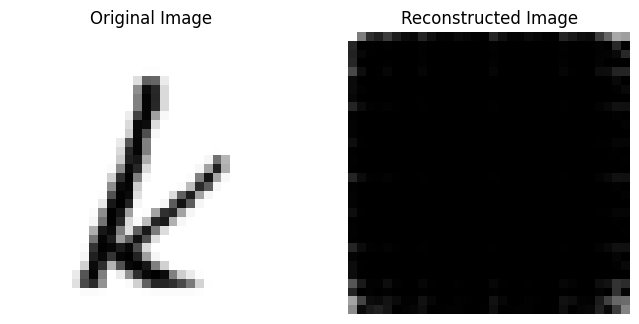

Reconstruction Error: 0.8812604546546936
----


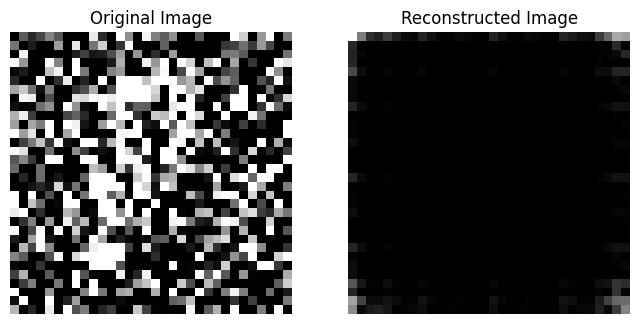

Reconstruction Error: 0.2959463596343994
----


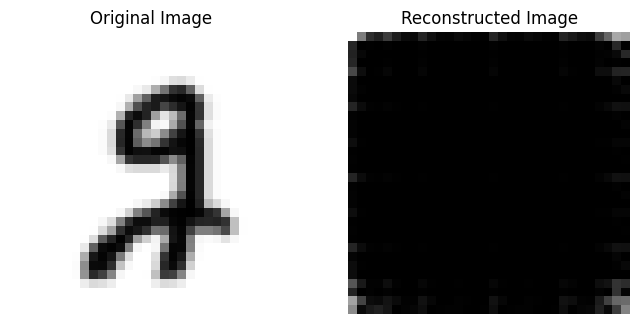

Reconstruction Error: 0.8290902972221375
----


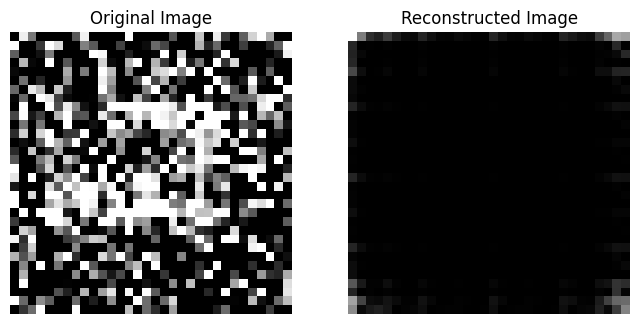

Reconstruction Error: 0.28136587142944336
----


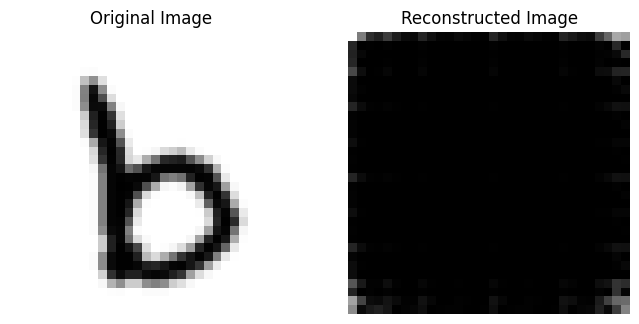

Reconstruction Error: 0.832271933555603
----


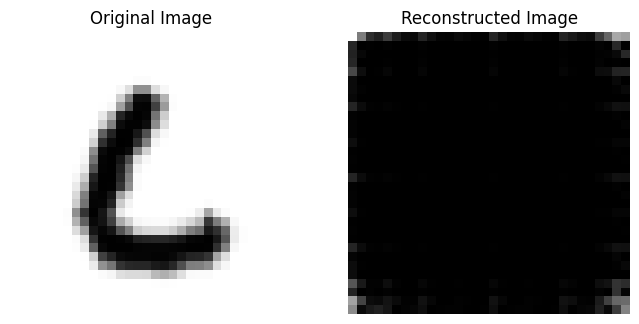

Reconstruction Error: 0.8442572355270386
----


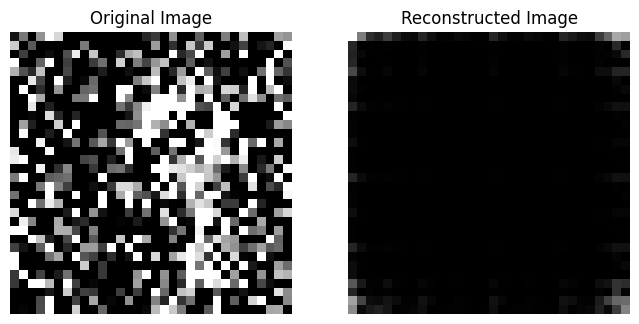

Reconstruction Error: 0.2543187141418457
----


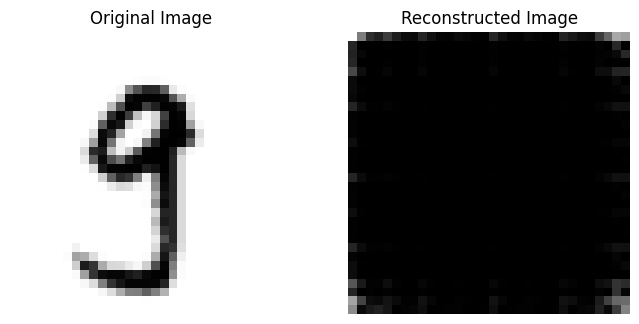

Reconstruction Error: 0.861181378364563
----


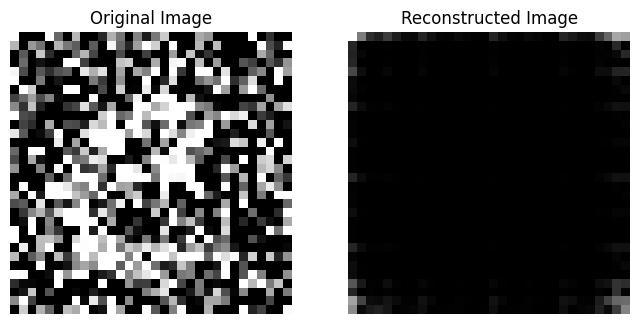

Reconstruction Error: 0.3095281720161438
----


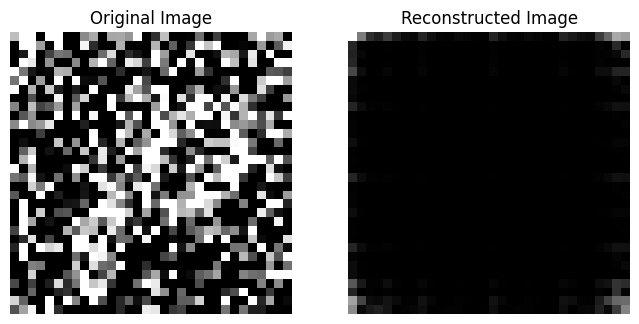

Reconstruction Error: 0.2839774489402771
----


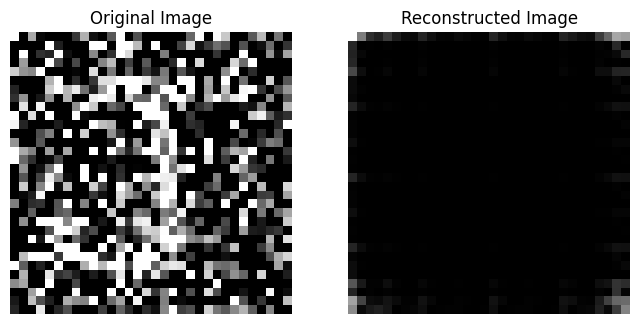

Reconstruction Error: 0.2537270784378052
----


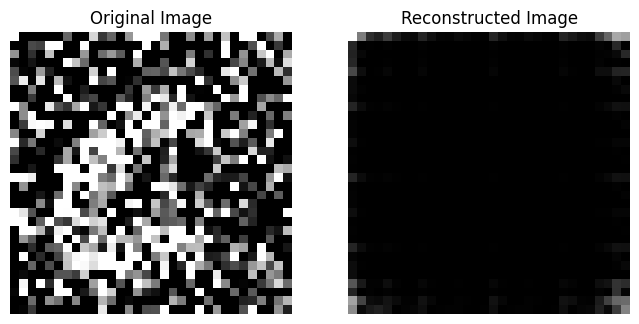

Reconstruction Error: 0.2719027101993561
----


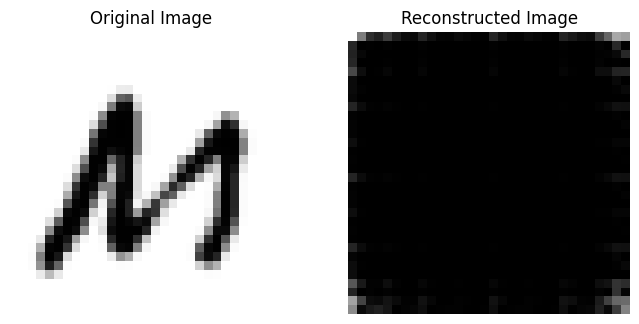

Reconstruction Error: 0.8057051301002502
----


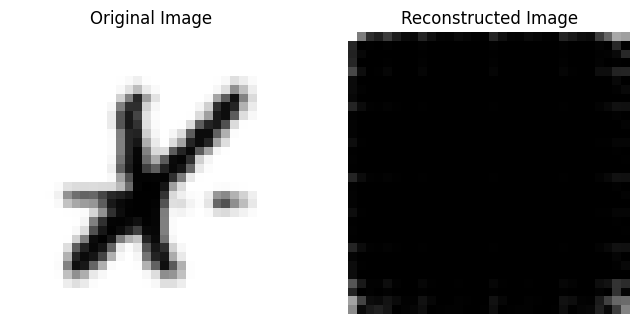

Reconstruction Error: 0.822438657283783
----


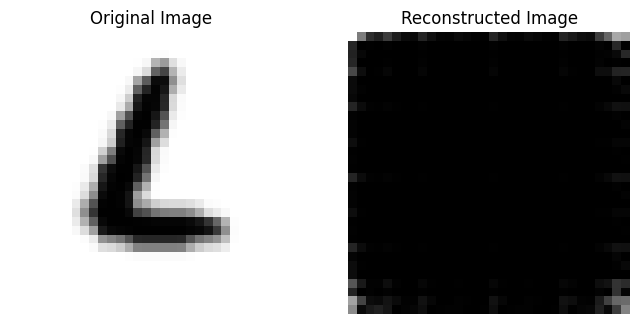

Reconstruction Error: 0.8492226004600525
----


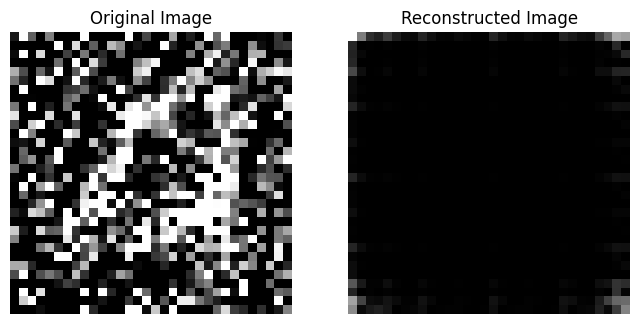

Reconstruction Error: 0.25471001863479614
----


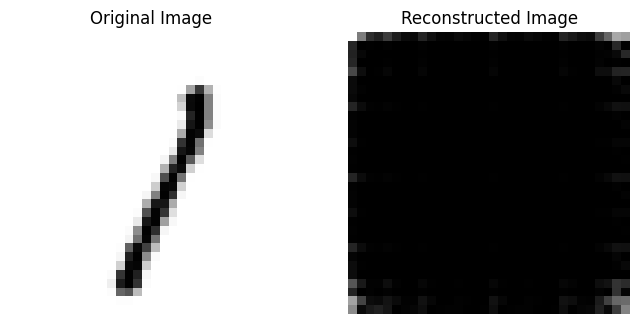

Reconstruction Error: 0.9327151775360107
----


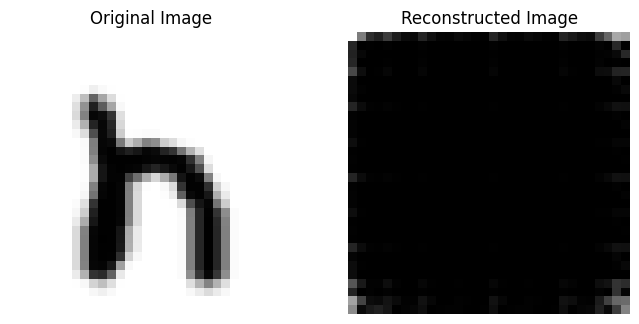

Reconstruction Error: 0.8211721181869507
----


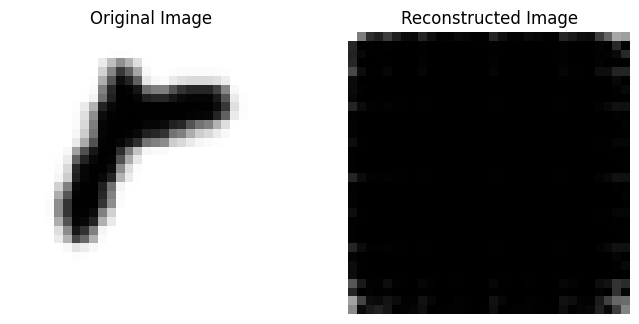

Reconstruction Error: 0.8327475190162659
----


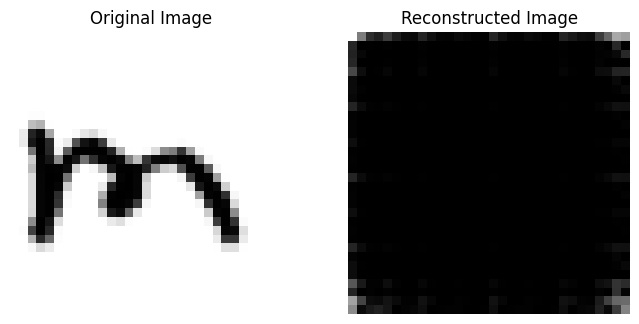

Reconstruction Error: 0.8719713687896729
----


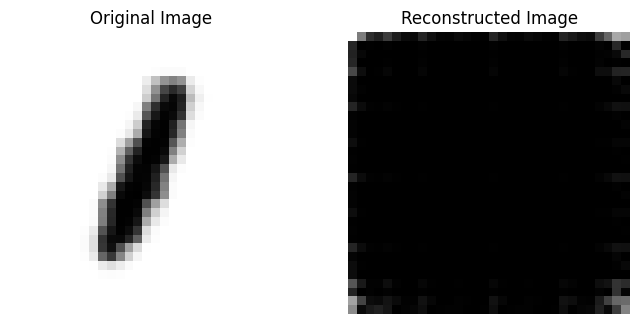

Reconstruction Error: 0.8888631463050842
----


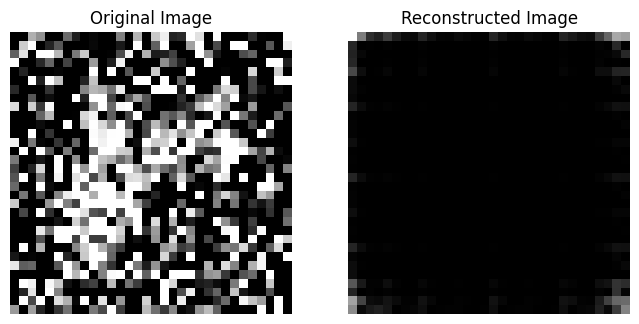

Reconstruction Error: 0.29061609506607056
----


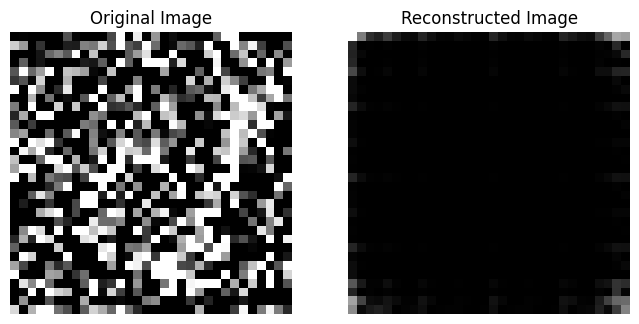

Reconstruction Error: 0.28140801191329956
----


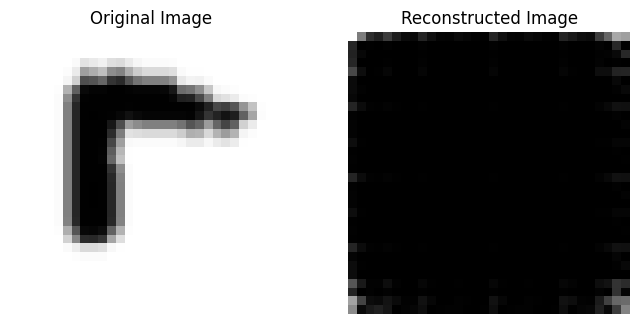

Reconstruction Error: 0.8080919981002808
----


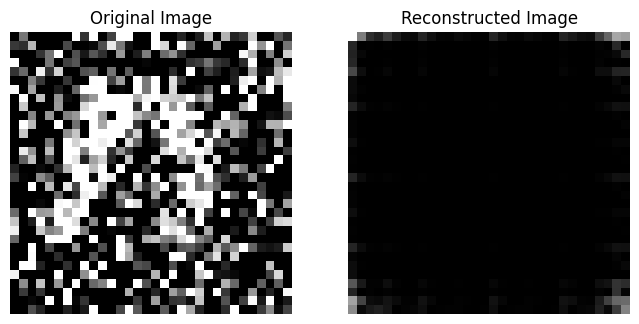

Reconstruction Error: 0.27699628472328186
----


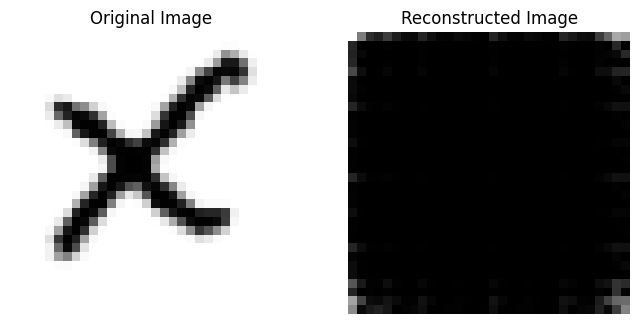

Reconstruction Error: 0.8346639275550842
----


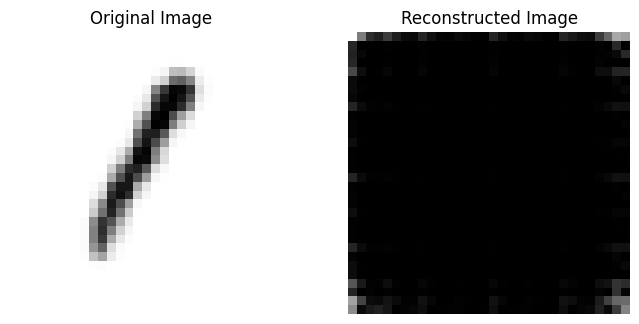

Reconstruction Error: 0.9220123291015625
----


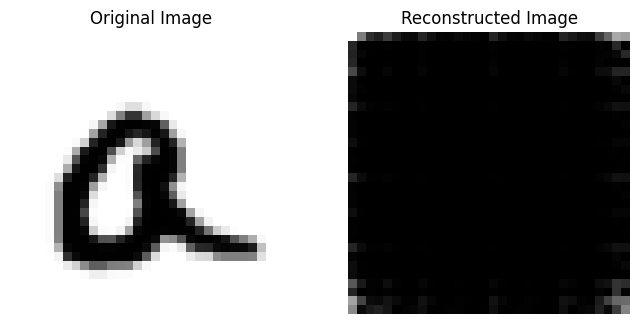

Reconstruction Error: 0.8086252212524414
----


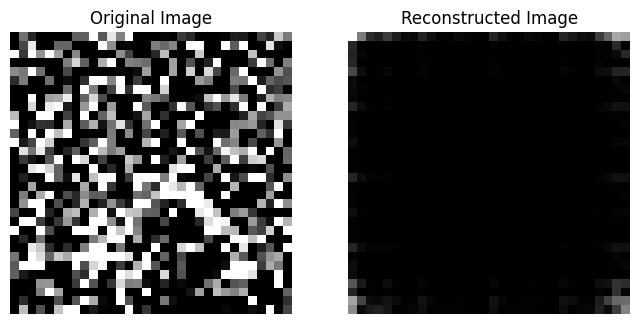

Reconstruction Error: 0.25565797090530396
----


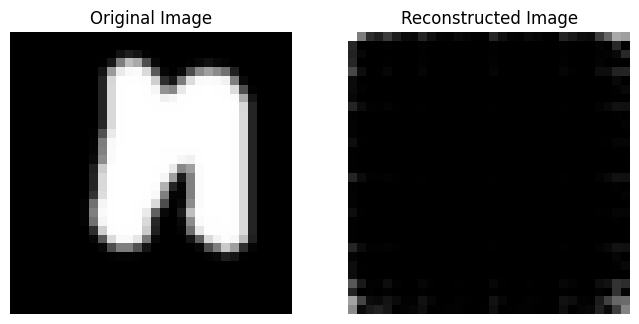

Reconstruction Error: 0.2616613507270813
----


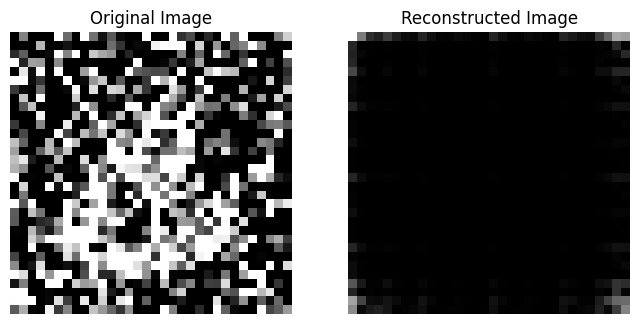

Reconstruction Error: 0.3127468228340149
----


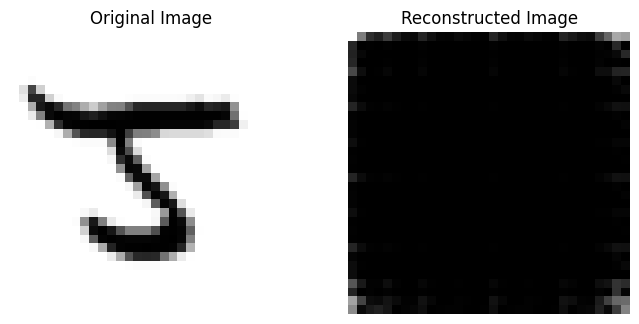

Reconstruction Error: 0.8491985201835632
----


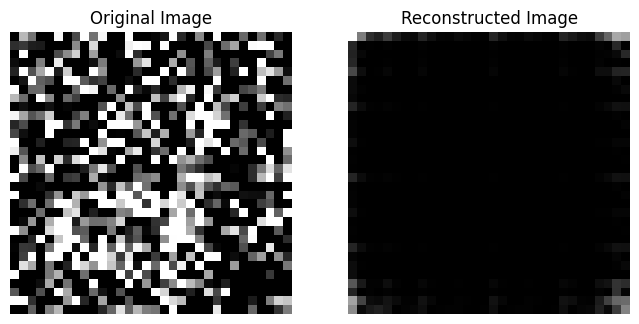

Reconstruction Error: 0.261025071144104
----


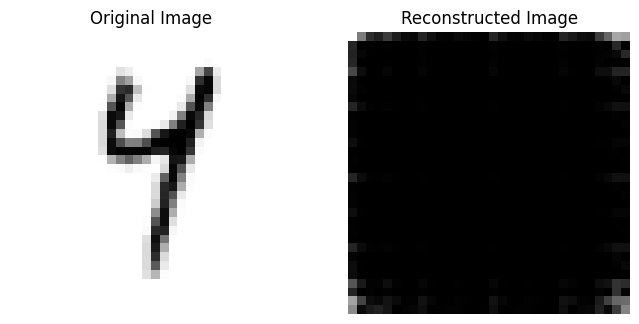

Reconstruction Error: 0.9084309339523315
----


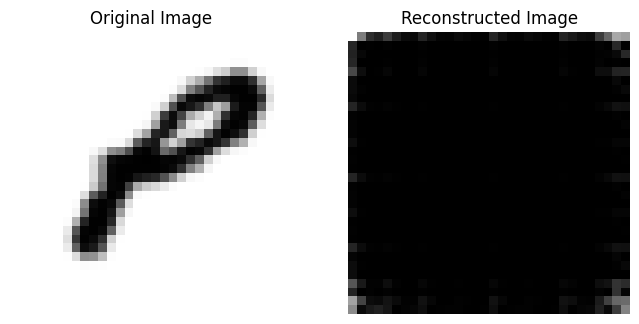

Reconstruction Error: 0.8403321504592896
----


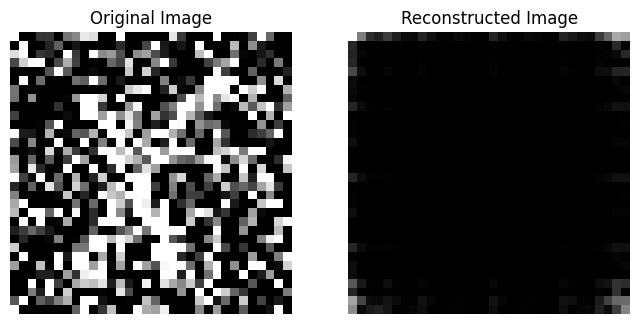

Reconstruction Error: 0.2837754487991333
----


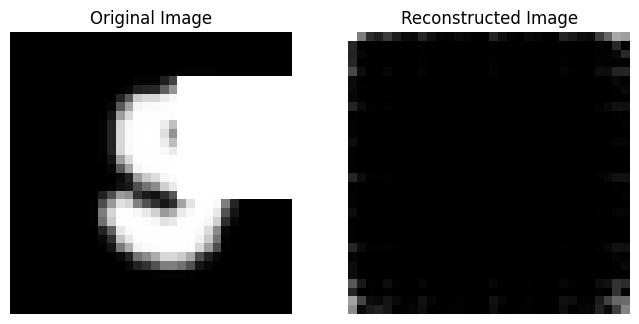

Reconstruction Error: 0.2973724603652954
----


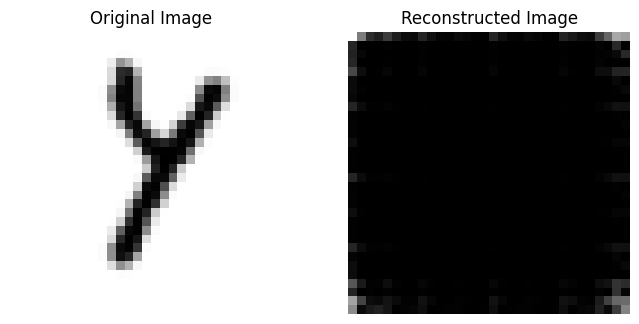

Reconstruction Error: 0.8906953930854797
----


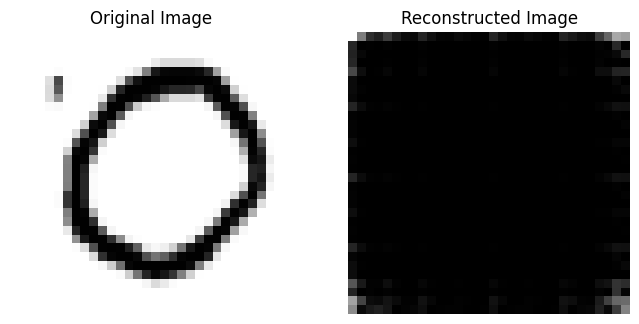

Reconstruction Error: 0.8080704212188721
----


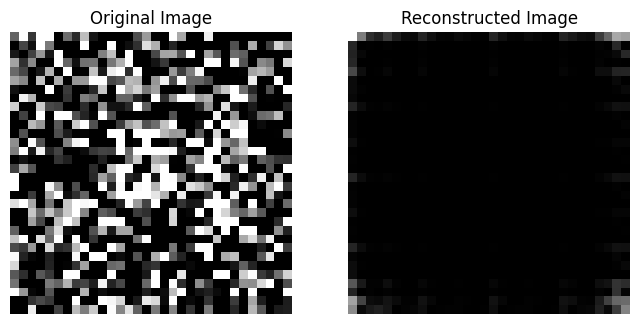

Reconstruction Error: 0.25828561186790466
----


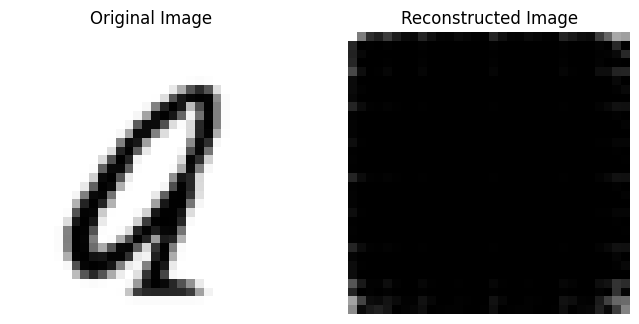

Reconstruction Error: 0.8246728181838989
----


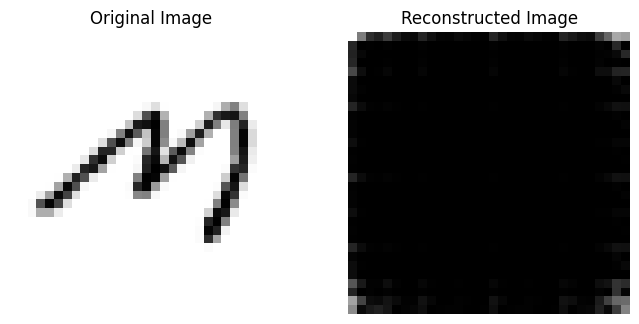

Reconstruction Error: 0.9020363688468933
----


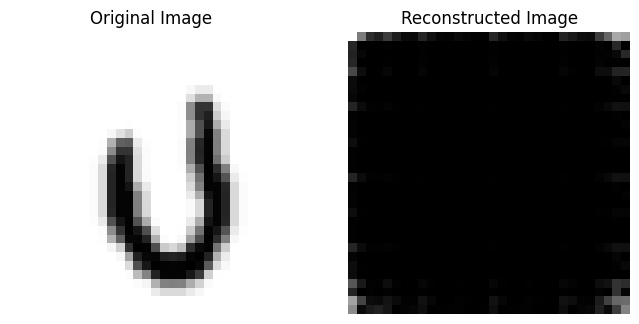

Reconstruction Error: 0.8514736890792847
----


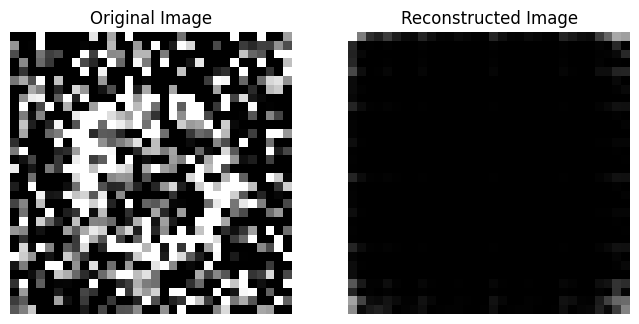

Reconstruction Error: 0.27808886766433716
----


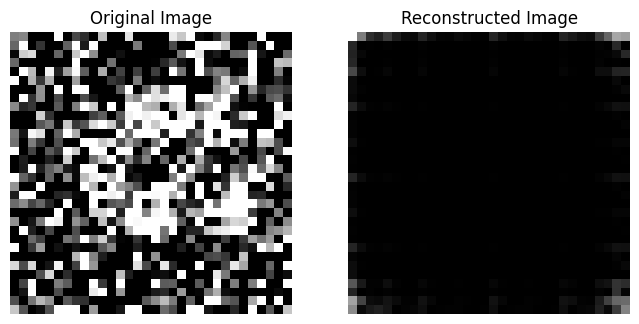

Reconstruction Error: 0.29275497794151306
----


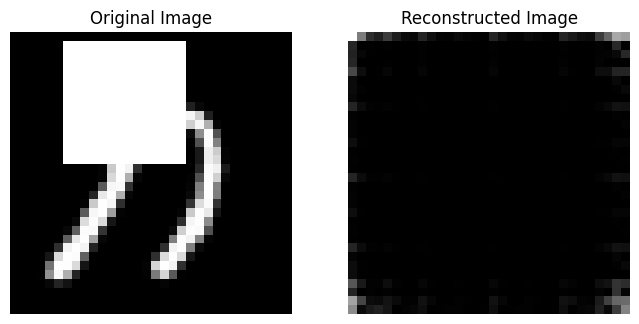

Reconstruction Error: 0.25756317377090454
----


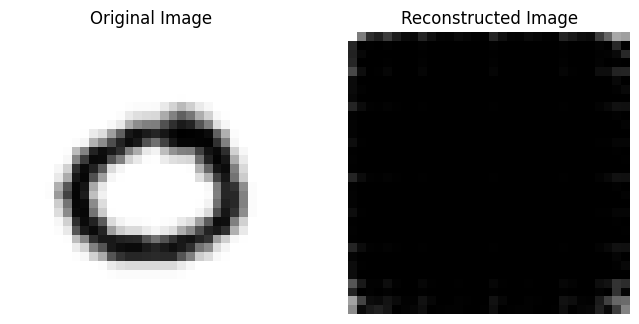

Reconstruction Error: 0.8230271339416504
----


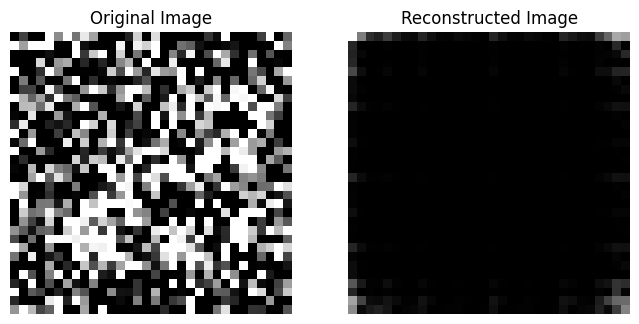

Reconstruction Error: 0.3122261166572571
----


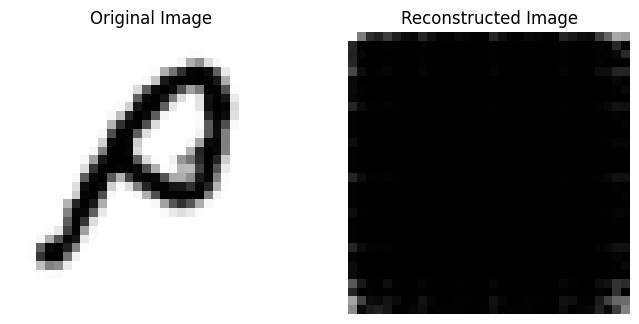

Reconstruction Error: 0.8323067426681519
----


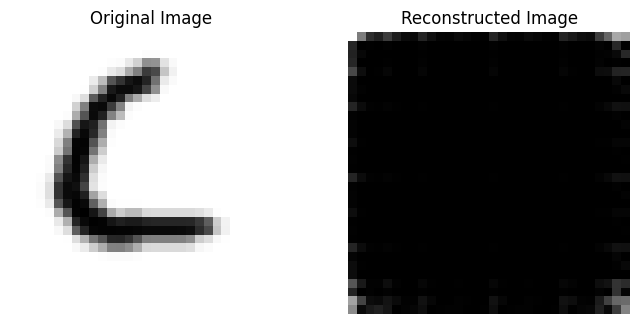

Reconstruction Error: 0.8632023930549622
----


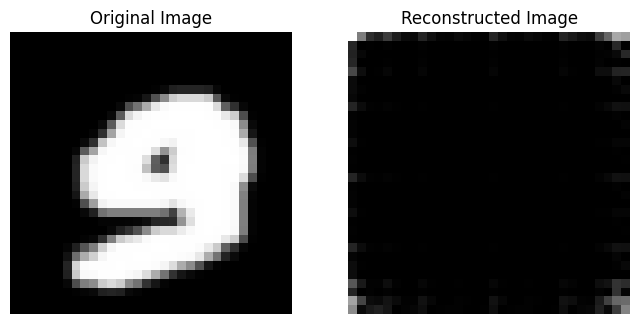

Reconstruction Error: 0.2704210877418518
----


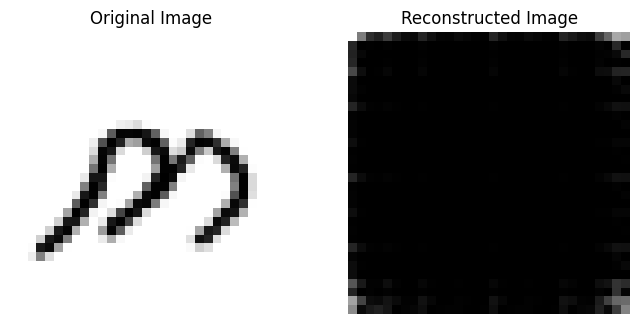

Reconstruction Error: 0.8834390640258789
----


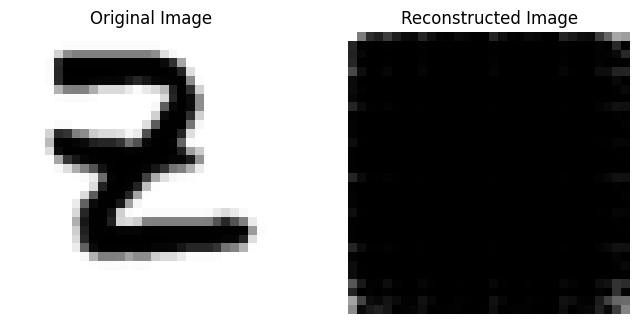

Reconstruction Error: 0.7456825971603394
----


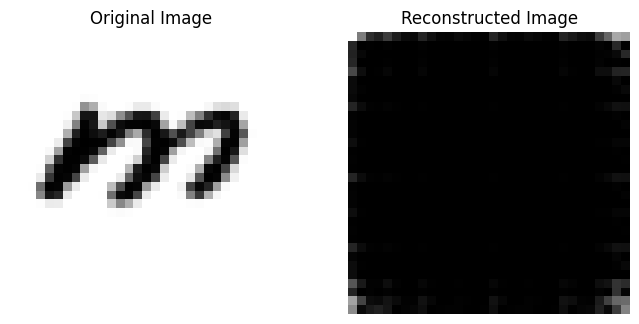

Reconstruction Error: 0.8657740354537964
----


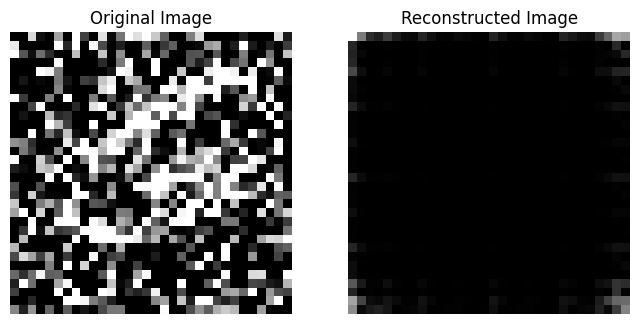

Reconstruction Error: 0.27382415533065796
----


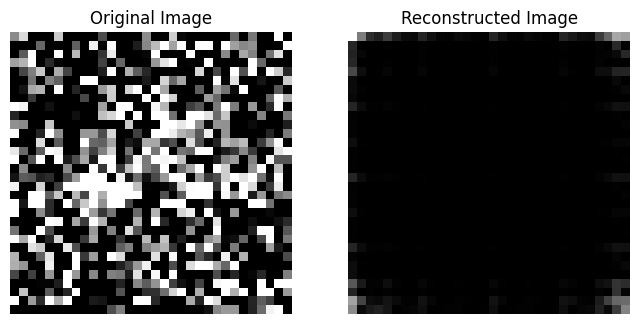

Reconstruction Error: 0.2687302827835083
----


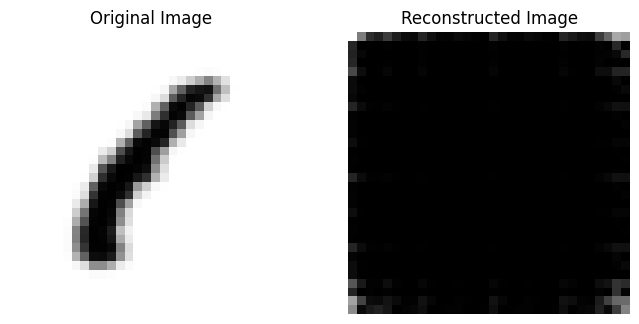

Reconstruction Error: 0.8813141584396362
----


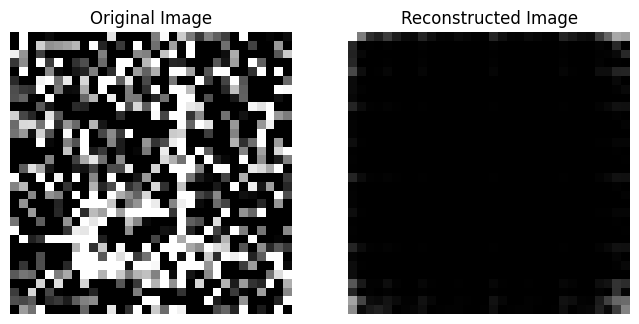

Reconstruction Error: 0.26946988701820374
----


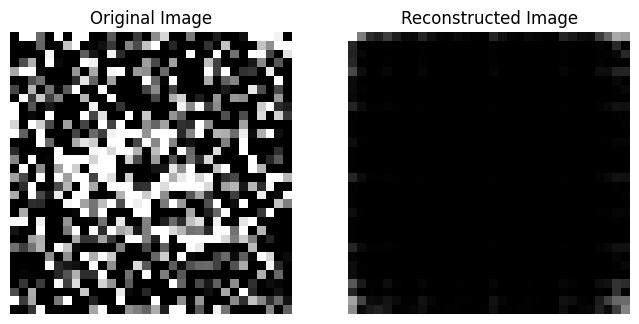

Reconstruction Error: 0.26515427231788635
----


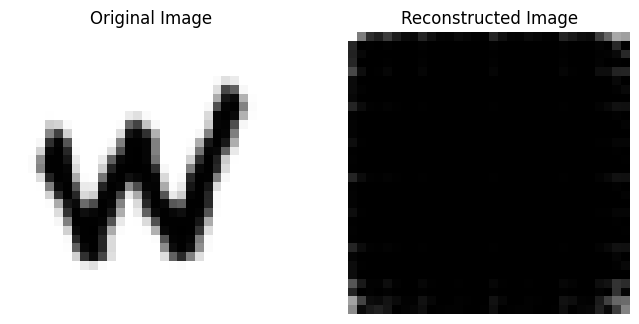

Reconstruction Error: 0.8029779195785522
----


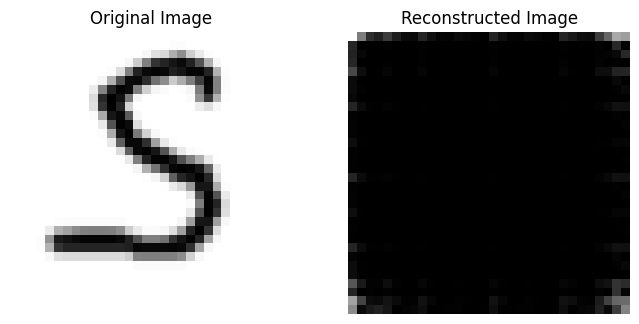

Reconstruction Error: 0.8443301320075989
----


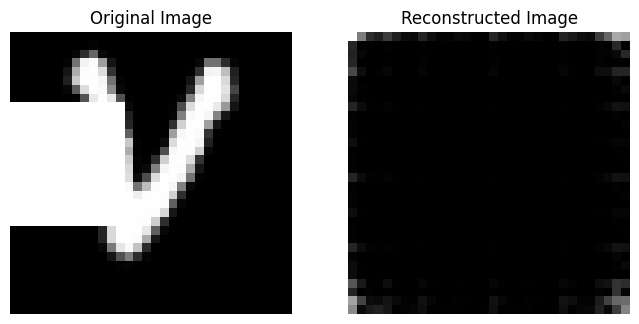

Reconstruction Error: 0.2756970226764679
----


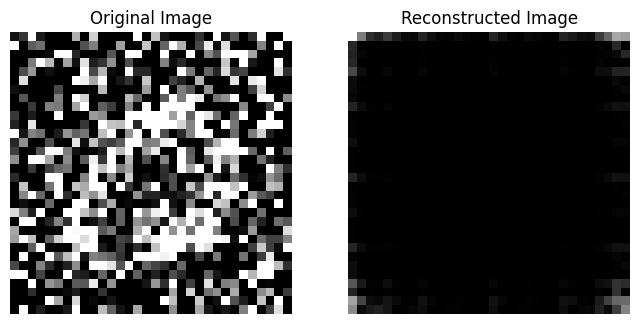

Reconstruction Error: 0.284623920917511
----


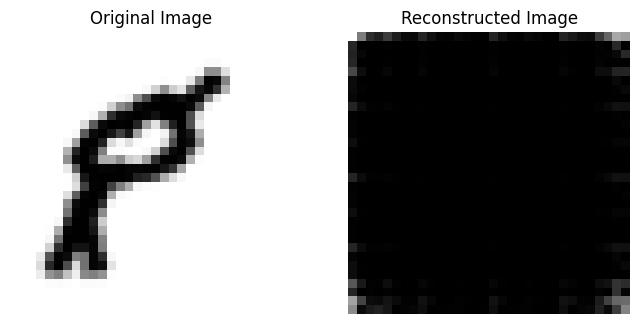

Reconstruction Error: 0.8335307240486145
----


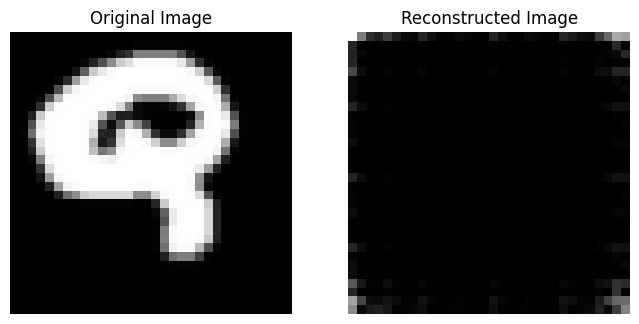

Reconstruction Error: 0.25485169887542725
----


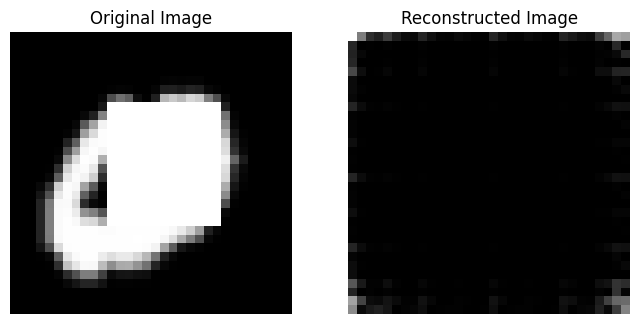

Reconstruction Error: 0.28136661648750305
----


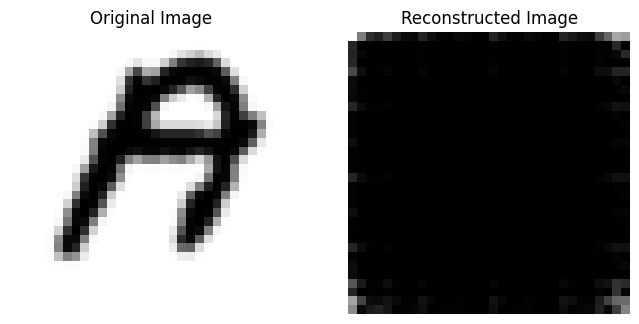

Reconstruction Error: 0.7683861255645752
----


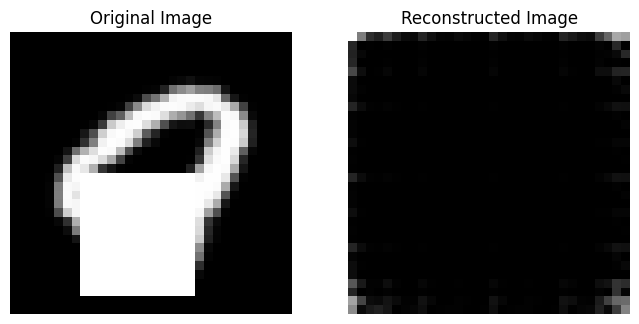

Reconstruction Error: 0.2737134099006653
----


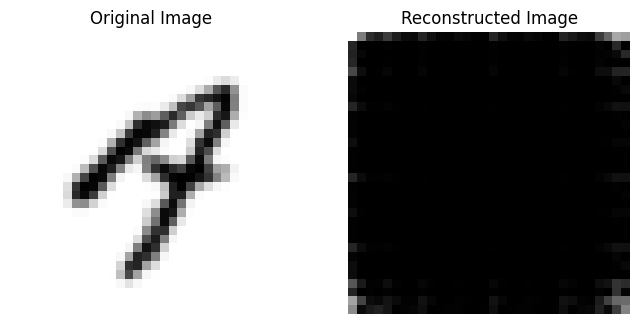

Reconstruction Error: 0.8666946887969971
----


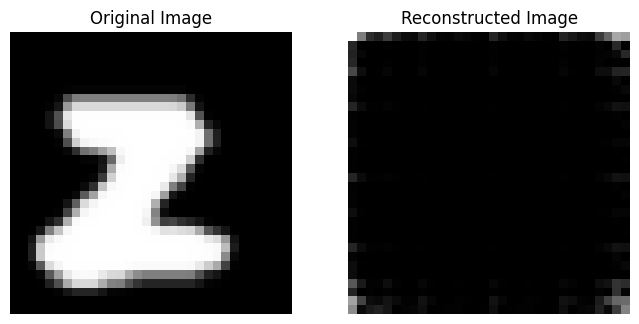

Reconstruction Error: 0.25336676836013794
----


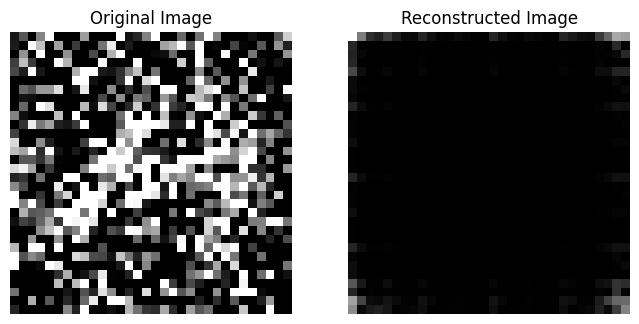

Reconstruction Error: 0.25912725925445557
----


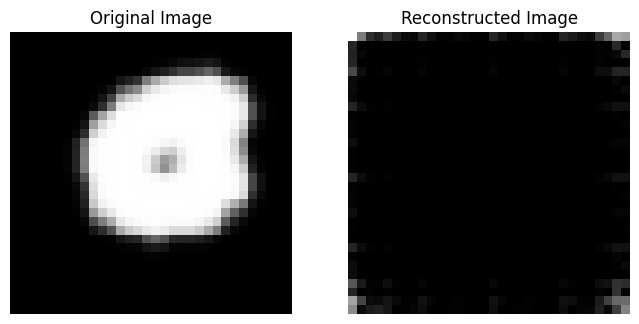

Reconstruction Error: 0.257379412651062
----


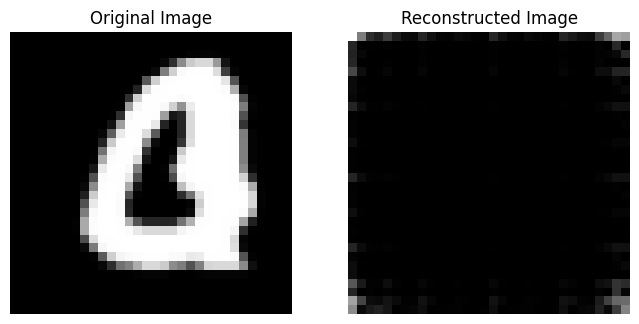

Reconstruction Error: 0.2531539797782898
----


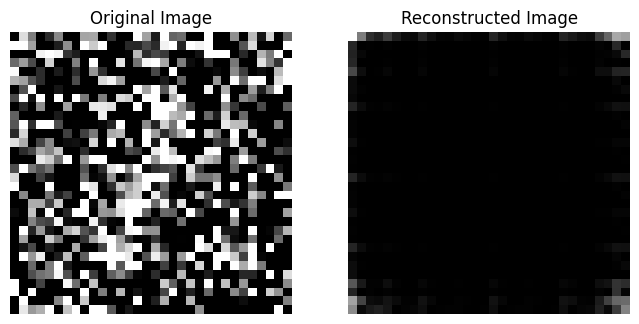

Reconstruction Error: 0.25311145186424255
----


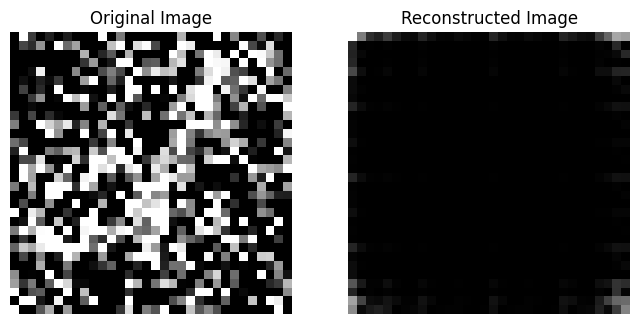

Reconstruction Error: 0.2777646780014038
----


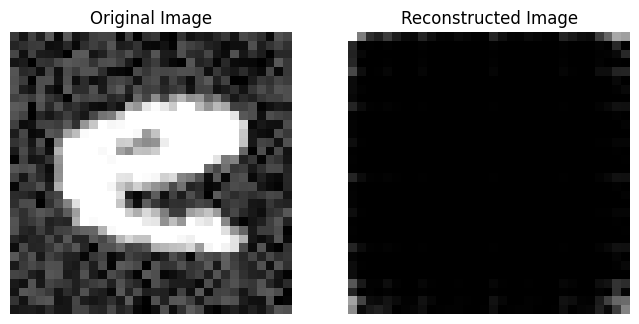

Reconstruction Error: 0.25712093710899353
----


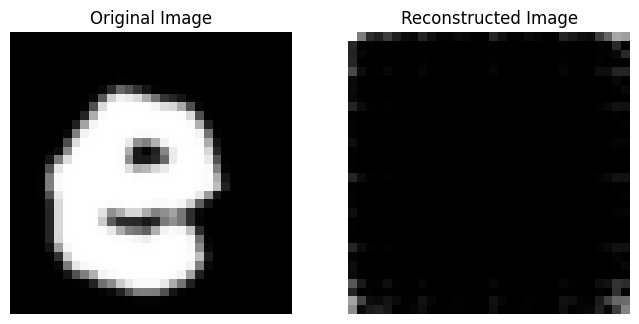

Reconstruction Error: 0.27340054512023926
----


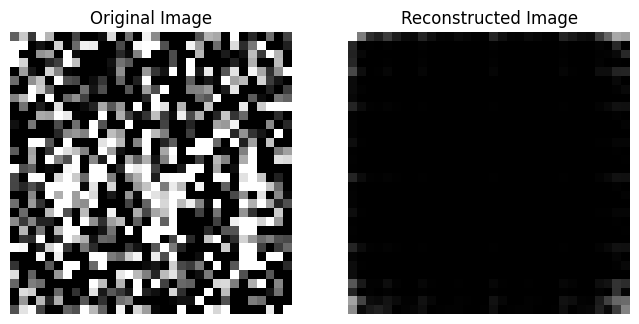

Reconstruction Error: 0.28622955083847046
----


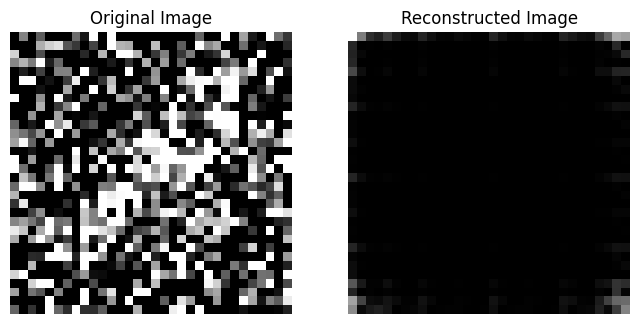

Reconstruction Error: 0.27235257625579834
----


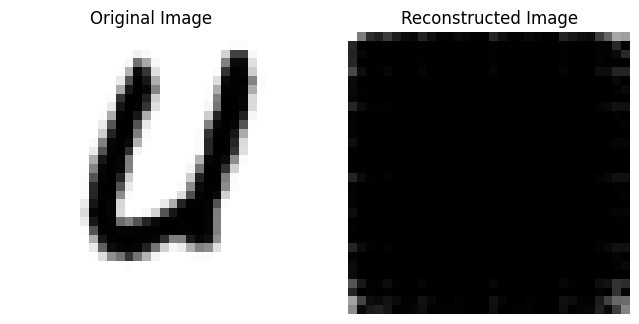

Reconstruction Error: 0.7971895933151245
----


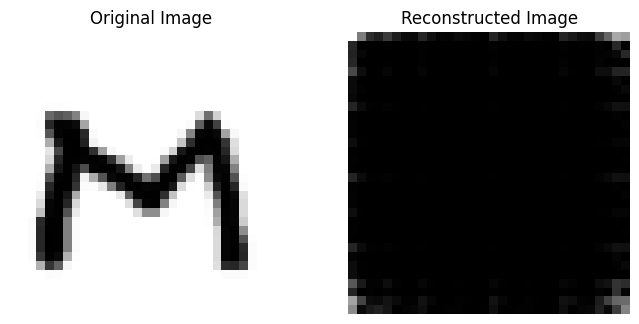

Reconstruction Error: 0.8220733404159546
----


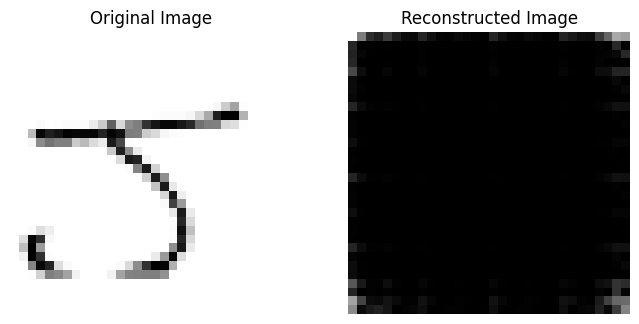

Reconstruction Error: 0.9211505651473999
----


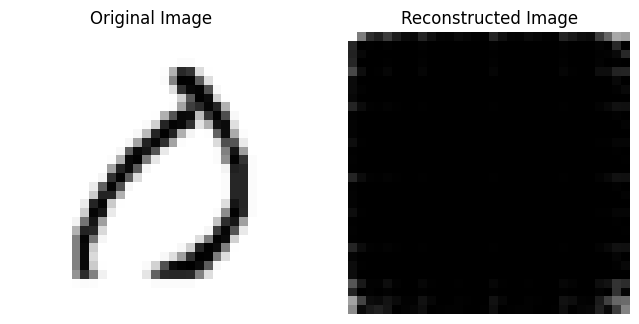

Reconstruction Error: 0.8656216859817505
----


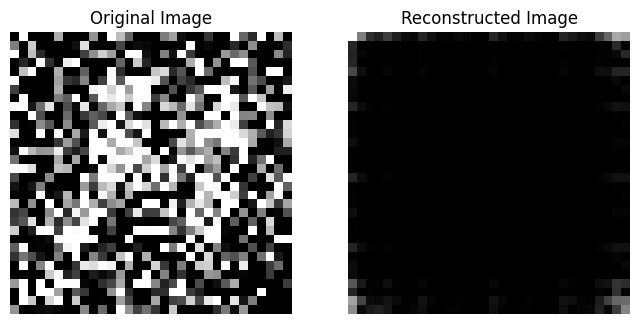

Reconstruction Error: 0.3105325698852539
----


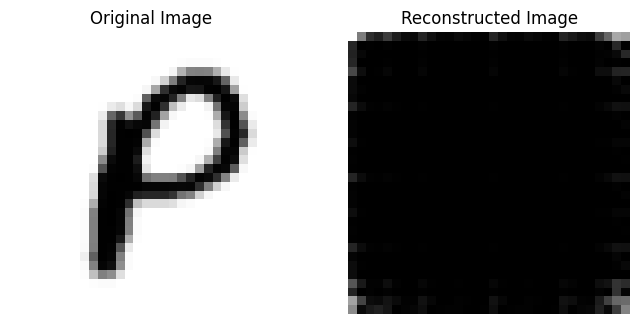

Reconstruction Error: 0.8291170597076416
----


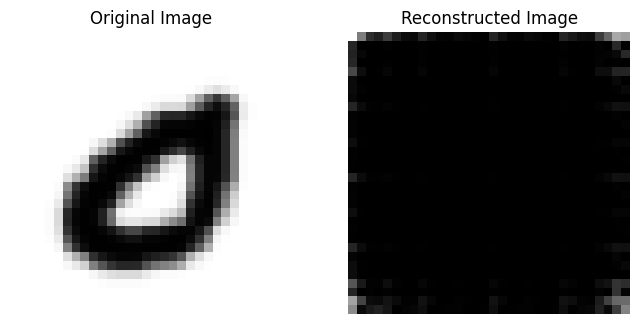

Reconstruction Error: 0.7485164403915405
----


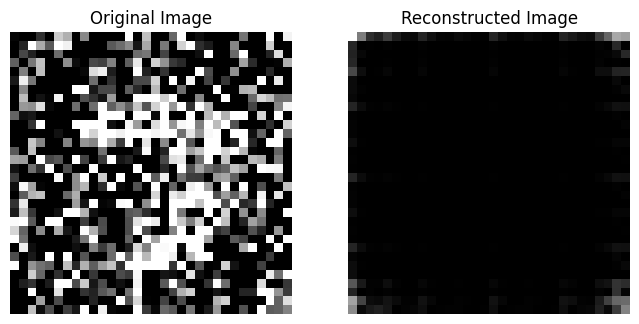

Reconstruction Error: 0.27581697702407837
----


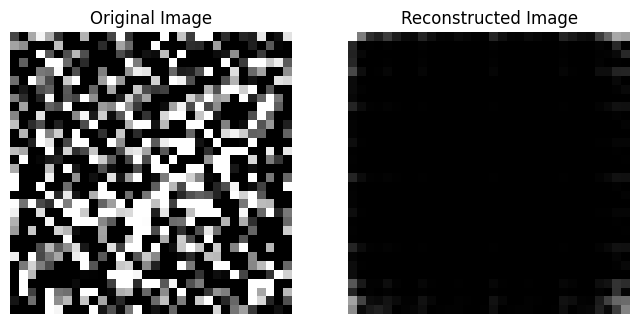

Reconstruction Error: 0.28152143955230713
----


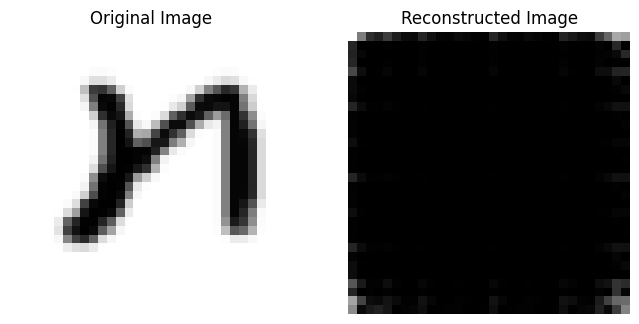

Reconstruction Error: 0.8174111843109131
----


In [50]:
# Visualize anomalies
def plot_anomalies(original_data, reconstructed_data, anomalies):
    for idx in np.where(anomalies)[0][:100]:  # Plot first 5 anomalies
        plt.figure(figsize=(8, 4))
        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_data[idx, 0].cpu(), cmap="gray")
        plt.title("Original Image")
        plt.axis("off")
        # Reconstructed image
        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed_data[idx, 0].cpu(), cmap="gray")
        plt.title("Reconstructed Image")
        plt.axis("off")
        plt.show()
        # Show the reconstruction error
        print(f"Reconstruction Error: {errors[idx]}")
        print("----")


# Get reconstructed images for anomalies
model.eval()
with torch.no_grad():
    corrupted_images_tensor = corrupted_images_tensor.to(device)
    reconstructed = model(corrupted_images_tensor)
plot_anomalies(corrupted_images_tensor, reconstructed, anomalies)
